In [1]:
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, Input, applications
from transformers import AutoConfig, TFAutoModel, ViTFeatureExtractor, ViTConfig
from tensorflow.keras.applications import ResNet50, DenseNet121
from sklearn.utils import resample
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    Dense, Flatten, Reshape, LayerNormalization, Dropout,
    MultiHeadAttention, Add, GlobalAveragePooling1D, GlobalAveragePooling2D, Layer
)
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
)
from tensorflow.keras.layers import MaxPooling2D, concatenate, Activation, Dropout, Flatten, Dense
import warnings
warnings.filterwarnings("ignore")

In [2]:
meta_data = pd.read_csv('HAM10000_metadata.csv')

In [3]:
meta_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


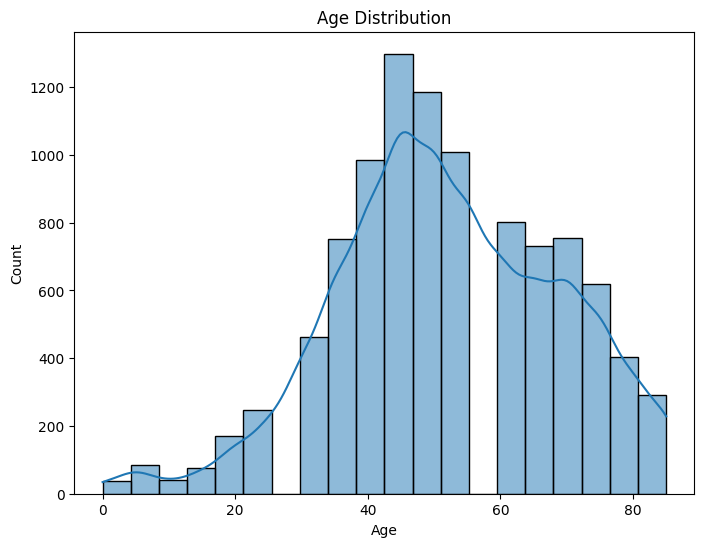

In [4]:
# Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(meta_data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

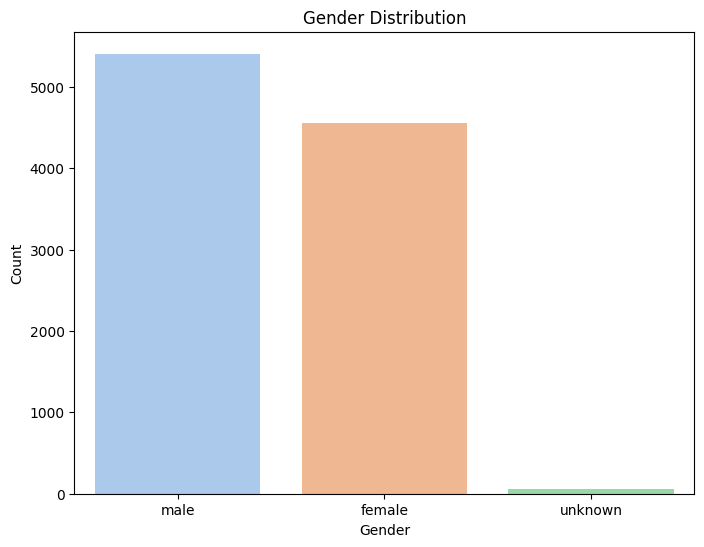

In [5]:
# Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=meta_data, x='sex', palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

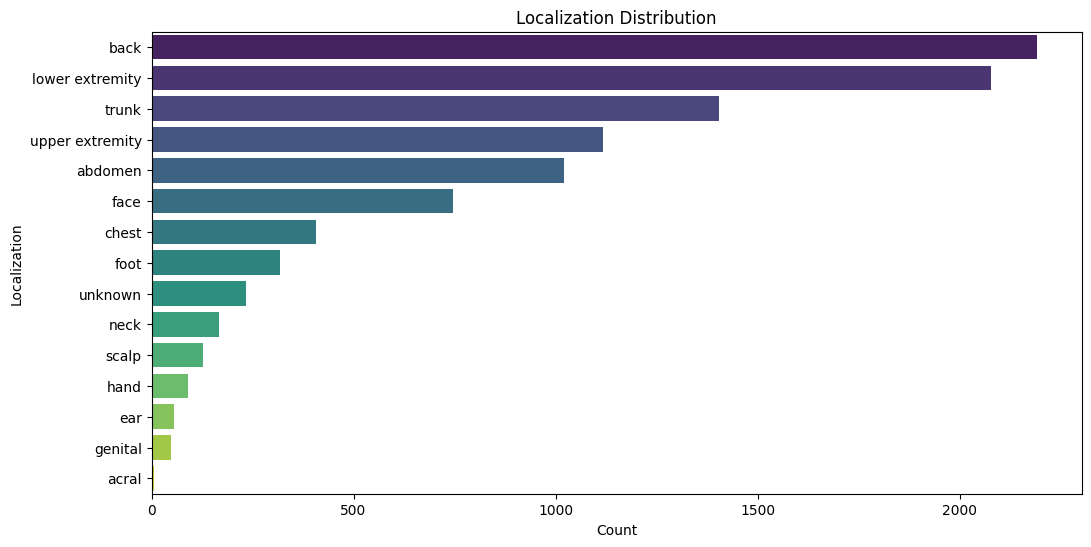

In [6]:
# Localization Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=meta_data, y='localization', palette='viridis', order=meta_data['localization'].value_counts().index)
plt.title('Localization Distribution')
plt.xlabel('Count')
plt.ylabel('Localization')
plt.show()

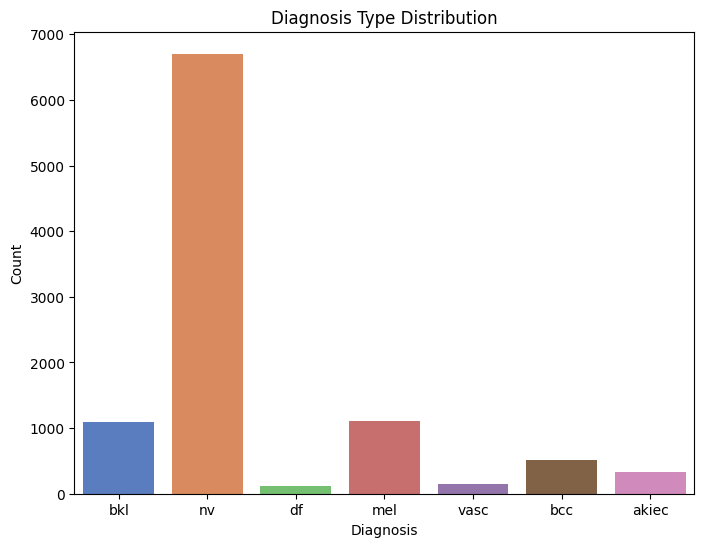

In [7]:
# Diagnosis Type Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=meta_data, x='dx', palette='muted')
plt.title('Diagnosis Type Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

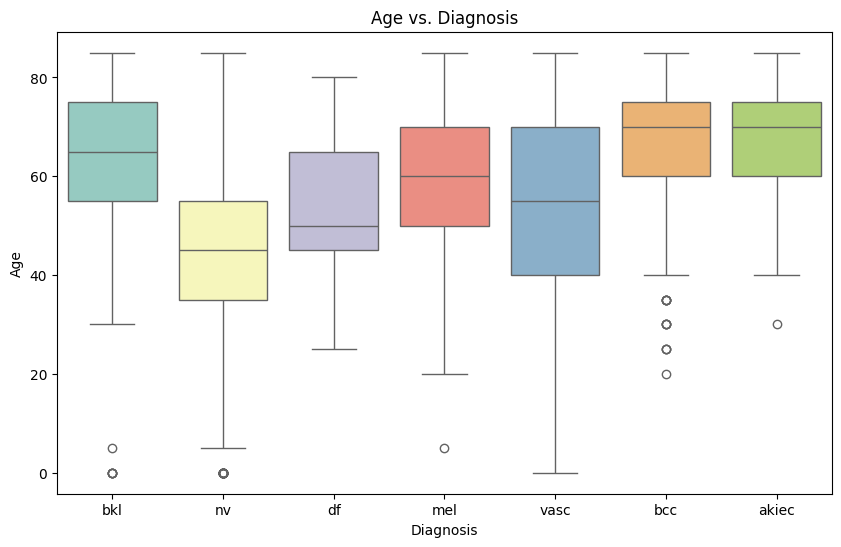

In [8]:
# Age vs. Diagnosis (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=meta_data, x='dx', y='age', palette='Set3')
plt.title('Age vs. Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.show()

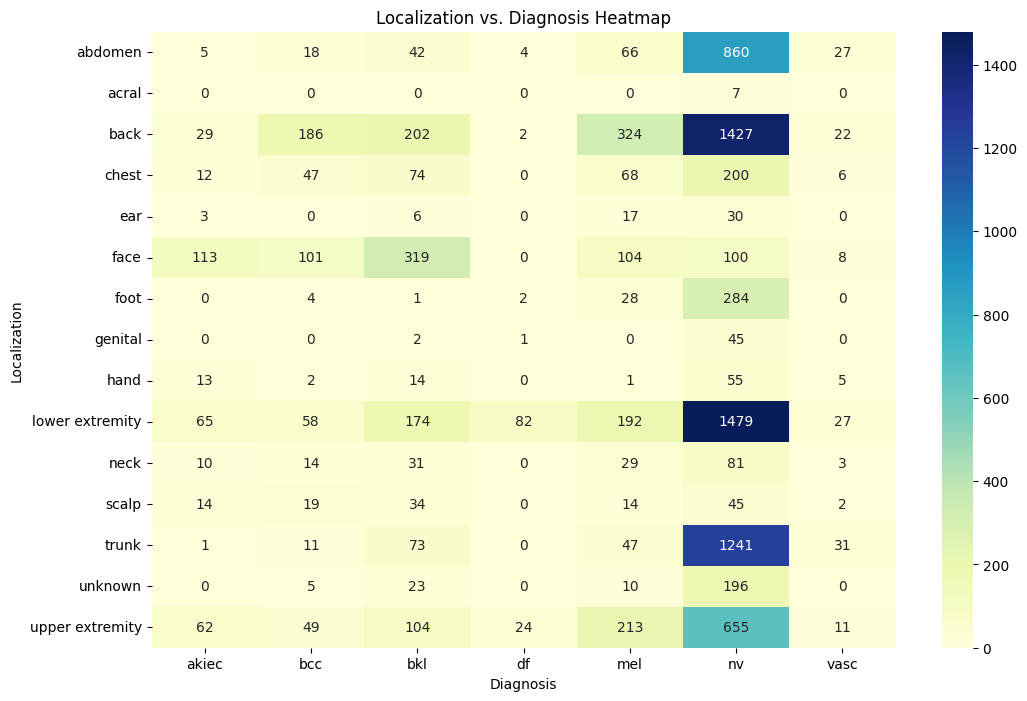

In [9]:
localization_dx = pd.crosstab(meta_data['localization'], meta_data['dx'])
plt.figure(figsize=(12, 8))
sns.heatmap(localization_dx, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Localization vs. Diagnosis Heatmap')
plt.xlabel('Diagnosis')
plt.ylabel('Localization')
plt.show()

In [10]:
# Collect image paths for all 7 classes
def collect_image_paths(directory):
    class_labels = os.listdir(directory)  # Each folder corresponds to a class
    data = []
    for label in class_labels:
        class_dir = os.path.join(directory, label)
        image_paths = [
            os.path.join(class_dir, fname)
            for fname in os.listdir(class_dir)
            if fname.endswith(('.jpg', '.jpeg', '.png'))
        ]
        data.extend([(path, label) for path in image_paths])
    return pd.DataFrame(data, columns=["filepath", "label"])

In [11]:
# Prepare data DataFrame
data_df = collect_image_paths("segmented_sam")
data_df

,filepath,label
0,segmented_sam/vasc/ISIC_0031759.jpg,vasc
1,segmented_sam/vasc/ISIC_0031090.jpg,vasc
2,segmented_sam/vasc/ISIC_0024662.jpg,vasc
3,segmented_sam/vasc/ISIC_0029889.jpg,vasc
4,segmented_sam/vasc/ISIC_0026693.jpg,vasc
...,...,...
9996,segmented_sam/mel/ISIC_0029914.jpg,mel
9997,segmented_sam/mel/ISIC_0027964.jpg,mel
9998,segmented_sam/mel/ISIC_0026094.jpg,mel
9999,segmented_sam/mel/ISIC_0027560.jpg,mel


In [12]:
# Split into train, validation, and test sets (70/20/10 split)
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df["label"], random_state=42)

In [13]:
# Verify the splits
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 7000
Validation size: 2000
Test size: 1001


In [14]:
# Augmented Data Generator for Training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,          # Random rotation up to 20 degrees
    zoom_range=0.15,            # Random zoom between 85% and 115%
    width_shift_range=0.1,      # Horizontal shift up to 10%
    height_shift_range=0.1,     # Vertical shift up to 10%
    shear_range=0.15,           # Shear intensity
    horizontal_flip=True,       # Random horizontal flip
    brightness_range=(0.8, 1.2) # Adjust brightness between 80%-120%
)

In [15]:
# No augmentation for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [16]:
# Train generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Multi-class classification
    shuffle=True
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 7000 validated image filenames belonging to 7 classes.
Found 2000 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.


In [17]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

In [18]:
# Convert to a dictionary for TensorFlow
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: 4.366812227074236, 1: 2.7777777777777777, 2: 1.3003901170351104, 3: 12.5, 4: 1.2836970474967908, 5: 0.21308331557639038, 6: 11.11111111111111}


In [19]:
# Create a Weighted Loss Function
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        weights = tf.reduce_sum(y_true * class_weights, axis=1)
        unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(weights * unweighted_loss)
    return loss

In [20]:
# Create a TensorFlow-compatible class weights tensor
class_weights_tensor = tf.constant(list(class_weights_dict.values()), dtype=tf.float32)

In [21]:
weighted_loss = weighted_categorical_crossentropy(class_weights_tensor)

## Model 1 - Basic CNN

In [22]:
# Define the CNN model
def build_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization

    # Output Layer
    model.add(layers.Dense(7, activation='softmax'))  # 7 classes

    return model

In [23]:
# Build the model
cnn_model = build_cnn_model()

# Summary of the model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             9

 Total params: 13,270,471 (50.62 MB)

 Trainable params: 13,268,999 (50.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [24]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [25]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='cnn_model_multi.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [26]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 113s 449ms/step - accuracy: 0.2254 - loss: 2.3436 - val_accuracy: 0.0845 - val_loss: 2.2594
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 412ms/step - accuracy: 0.2706 - loss: 1.9689 - val_accuracy: 0.3055 - val_loss: 1.7850
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 405ms/step - accuracy: 0.3326 - loss: 1.8322 - val_accuracy: 0.0925 - val_loss: 1.8012
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 406ms/step - accuracy: 0.2844 - loss: 1.8406 - val_accuracy: 0.0655 - val_loss: 2.6787
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 410ms/step - accuracy: 0.3306 - loss: 1.7442 - val_accuracy: 0.4860 - val_loss: 1.5606
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 410ms/step - accuracy: 0.3489 - loss: 1.7131 - val_accuracy: 0.5325 - val_loss: 1.5502
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 409ms/step - accuracy: 0.3396 - loss: 1.6988 - val_accuracy: 0.5065 - val_loss: 1.5698
Epoch 8/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 409ms/step - accuracy: 0.3744 - loss:

In [27]:
# Save history
with open('cnn_history.json', 'w') as f:
    json.dump(cnn_history.history, f)

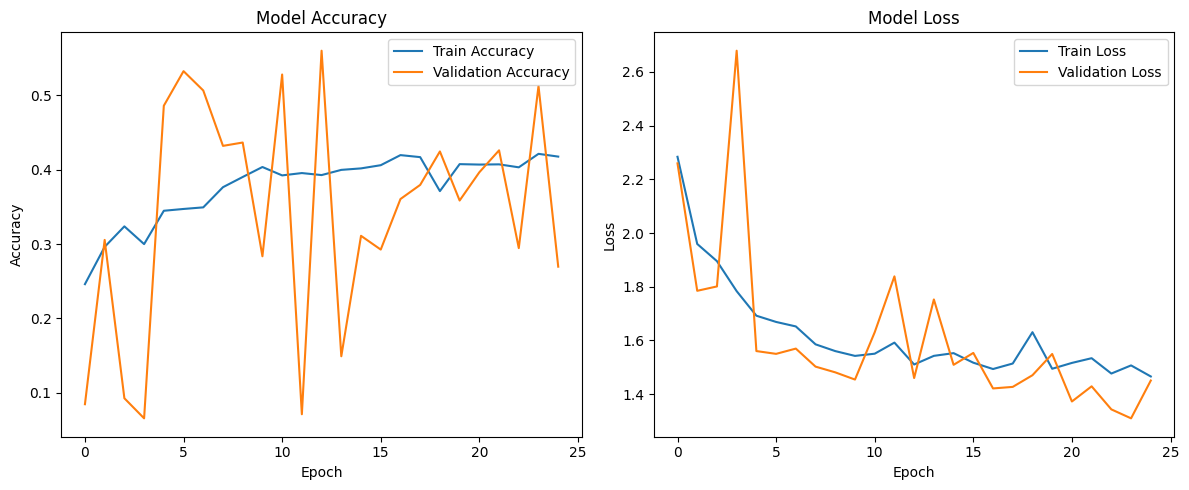

In [28]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot accuracy in the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss in the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [29]:
cnn_model = load_model('cnn_model_multi.keras', custom_objects={'custom_loss': weighted_loss})

In [30]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5412 - loss: 1.6072
Test Loss: 1.5219
Test Accuracy: 0.5694


In [31]:
# Get predictions and true labels
predictions = cnn_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class indices
true_labels = test_generator.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


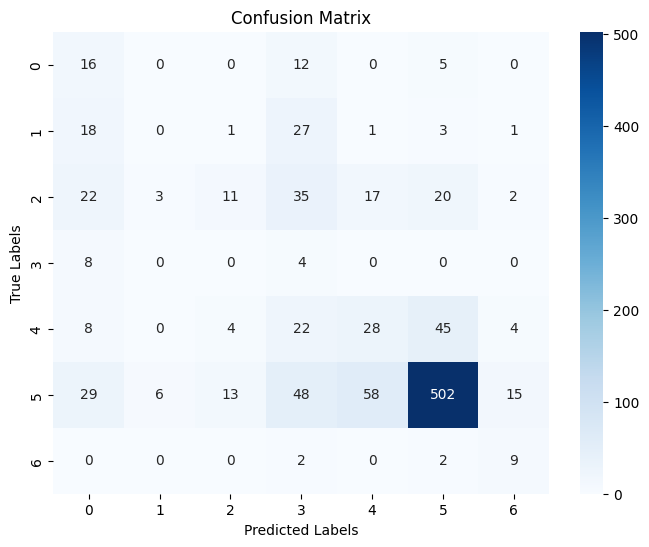

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [33]:
# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [34]:
# Specificity
specificities = []
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)
average_specificity = np.mean(specificities)

In [35]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {average_specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5694
Precision: 0.6640
Recall (Sensitivity): 0.5694
Specificity: 0.9143
F1-Score: 0.5993


## Model 2- ResNet50 with Transformer

In [36]:
# Define input
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

In [37]:
# CNN Backbone
cnn_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [38]:
cnn_output = cnn_base.output  # Shape: (None, 7, 7, 2048)

In [39]:
# Reshape CNN output to sequence
sequence_length = cnn_output.shape[1] * cnn_output.shape[2]  # 7*7=49
embedding_dim = cnn_output.shape[3]  # 2048

In [40]:
x = Reshape((sequence_length, embedding_dim))(cnn_output)  # Shape: (None, 49, 2048)

In [41]:
# Reduce Embedding Dimension
embedding_dim_reduced = 512  # Reduce for computational efficiency
x = Dense(embedding_dim_reduced)(x)

In [42]:
# Transformer Block
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(embedding_dim_reduced)(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Add()([attention_output, ff_output])  # Residual connection
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)

    return ff_output

In [43]:
# Parameters for transformer block
num_heads = 8
key_dim = embedding_dim_reduced // num_heads  # Ensure this is an integer
ff_dim = 512  # Feed-forward layer dimension
num_transformer_blocks = 2

In [44]:
for _ in range(num_transformer_blocks):
    x = transformer_block(x, num_heads, key_dim, ff_dim)

In [45]:
# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Classification Head
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Final Model
trans_model = Model(inputs=inputs, outputs=x)

In [46]:
trans_model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,925,895 (106.53 MB)

 Trainable params: 27,872,775 (106.33 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [47]:
# Compile Model
trans_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [48]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='trans_model_multi.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [49]:
# Define a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6
)

In [50]:
# Train Model
trans_history = trans_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 268s 771ms/step - accuracy: 0.3281 - loss: 1.8556 - val_accuracy: 0.0120 - val_loss: 2.4151 - learning_rate: 1.0000e-04
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 423ms/step - accuracy: 0.5167 - loss: 1.2696 - val_accuracy: 0.0830 - val_loss: 2.0629 - learning_rate: 1.0000e-04
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 413ms/step - accuracy: 0.5371 - loss: 1.2275 - val_accuracy: 0.0685 - val_loss: 2.0198 - learning_rate: 1.0000e-04
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 424ms/step - accuracy: 0.5855 - loss: 1.0655 - val_accuracy: 0.1870 - val_loss: 1.9475 - learning_rate: 1.0000e-04
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.5957 - loss: 1.0677 - val_accuracy: 0.6160 - val_loss: 1.4089 - learning_rate: 1.0000e-04
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 414ms/step - accuracy: 0.6139 - loss: 0.8766 - val_accuracy: 0.5725 - val_loss: 1.2787 - learning_rate: 1.0000e-04
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 4

In [51]:
# Save history
with open('trans_history.json', 'w') as f:
    json.dump(trans_history.history, f)

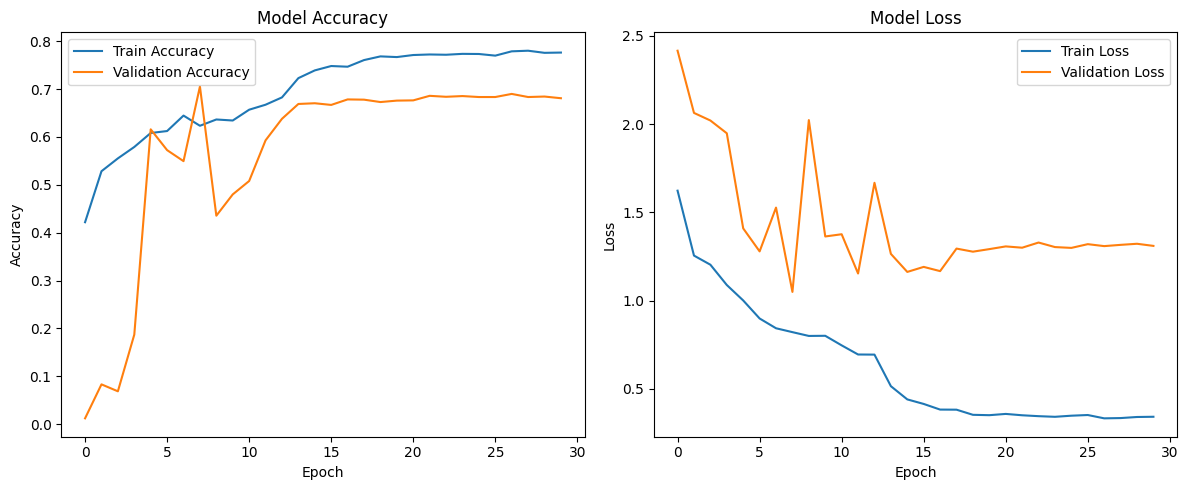

In [52]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot accuracy in the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(trans_history.history['accuracy'], label='Train Accuracy')
plt.plot(trans_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss in the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(trans_history.history['loss'], label='Train Loss')
plt.plot(trans_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [53]:
trans_model = load_model('trans_model_multi.keras', custom_objects={'custom_loss': weighted_loss})

In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = trans_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.6623 - loss: 1.2769
Test Loss: 1.1744
Test Accuracy: 0.6753


In [55]:
# Get predictions and true labels
predictions = trans_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class indices
true_labels = test_generator.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step


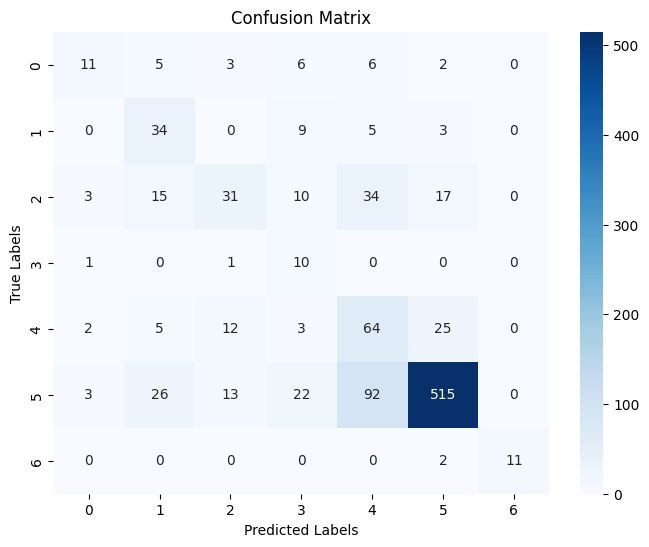

In [56]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [57]:
# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [58]:
# Specificity
specificities = []
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)
average_specificity = np.mean(specificities)

In [59]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {average_specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6753
Precision: 0.7577
Recall (Sensitivity): 0.6753
Specificity: 0.9359
F1-Score: 0.6990


## Model 3 - Inception Resnet v2 with soft attention

In [60]:
@tf.keras.utils.register_keras_serializable(package="Custom")
class SoftAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create the trainable scalar gamma as a weight
        self.gamma = self.add_weight(
            name='gamma',
            shape=(),
            initializer=tf.keras.initializers.Constant(0.01),
            trainable=True
        )
        # Define attention convolution layer
        self.attention_conv = layers.Conv2D(
            input_shape[-1],  # Number of channels in the input
            kernel_size=(1, 1),
            activation='sigmoid',
            kernel_initializer='he_normal'
        )

    def call(self, inputs):
        # Generate attention maps
        attention_maps = self.attention_conv(inputs)

        # Scale inputs by attention maps
        scaled_inputs = inputs * attention_maps
        scaled_inputs = self.gamma * scaled_inputs

        # Residual connection
        return inputs + scaled_inputs

In [61]:
def inception_resnet_v2_with_attention(input_shape, num_classes):
    # Load Inception ResNet v2 base model
    base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # Add Soft Attention at the last convolutional block
    x = base_model.get_layer('conv_7b_ac').output
    x = SoftAttention()(x)

    # Global Average Pooling and Fully Connected Layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [62]:
# Define the model
input_shape = (224, 224, 3)
num_classes = len(train_df['label'].unique())
irv2_model = inception_resnet_v2_with_attention(input_shape, num_classes)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [63]:
irv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [64]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='irv2_model_multi.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [65]:
# Define a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6
)

In [66]:
# Train the model
irv2_history = irv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 402s 886ms/step - accuracy: 0.3084 - loss: 1.7884 - val_accuracy: 0.6930 - val_loss: 1.7698 - learning_rate: 1.0000e-04
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 416ms/step - accuracy: 0.5699 - loss: 1.0904 - val_accuracy: 0.6710 - val_loss: 1.1943 - learning_rate: 1.0000e-04
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 418ms/step - accuracy: 0.6070 - loss: 0.8930 - val_accuracy: 0.5725 - val_loss: 1.0840 - learning_rate: 1.0000e-04
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 419ms/step - accuracy: 0.6574 - loss: 0.7843 - val_accuracy: 0.6740 - val_loss: 0.8791 - learning_rate: 1.0000e-04
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 420ms/step - accuracy: 0.6886 - loss: 0.6787 - val_accuracy: 0.6705 - val_loss: 0.8067 - learning_rate: 1.0000e-04
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 420ms/step - accuracy: 0.7062 - loss: 0.5667 - val_accuracy: 0.5840 - val_loss: 1.1857 - learning_rate: 1.0000e-04
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 99s 4

In [67]:
# Continue training for 10 more epochs
irv2_history_2 = irv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,  # Total epochs (25 + 10 = 35)
    initial_epoch=25,  # Start counting epochs from 25
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 26/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 433ms/step - accuracy: 0.8863 - loss: 0.1233 - val_accuracy: 0.7865 - val_loss: 1.0311 - learning_rate: 1.0000e-06
Epoch 27/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 418ms/step - accuracy: 0.8921 - loss: 0.1114 - val_accuracy: 0.7840 - val_loss: 1.0332 - learning_rate: 1.0000e-06
Epoch 28/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 421ms/step - accuracy: 0.8920 - loss: 0.1197 - val_accuracy: 0.7830 - val_loss: 1.0362 - learning_rate: 1.0000e-06
Epoch 29/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 419ms/step - accuracy: 0.8832 - loss: 0.1175 - val_accuracy: 0.7830 - val_loss: 1.0564 - learning_rate: 1.0000e-06
Epoch 30/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 419ms/step - accuracy: 0.8922 - loss: 0.1185 - val_accuracy: 0.7855 - val_loss: 1.0440 - learning_rate: 1.0000e-06
Epoch 31/35
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 436ms/step - accuracy: 0.8961 - loss: 0.1088 - val_accuracy: 0.7890 - val_loss: 1.0469 - learning_rate: 1.0000e-06
Epoch 32/35
219/219 ━━━━━━━━━━━━━━━━━━━━

In [68]:
import json

# Save history
with open('irv2_history.json', 'w') as f:
    json.dump(irv2_history.history, f)

# If continuing training
with open('irv2_history_2.json', 'w') as f:
    json.dump(irv2_history_2.history, f)

In [69]:
# Load history
#with open('irv2_history.json', 'r') as f:
#    history = json.load(f)

# Convert back to a format similar to Keras History
#print(history.keys())  # Check available keys

In [70]:
# Combining histories
full_history = {
    key: irv2_history.history[key] + irv2_history_2.history[key]
    for key in irv2_history.history.keys()
}

# Save combined history
with open('irv2_full_history.json', 'w') as f:
    json.dump(full_history, f)

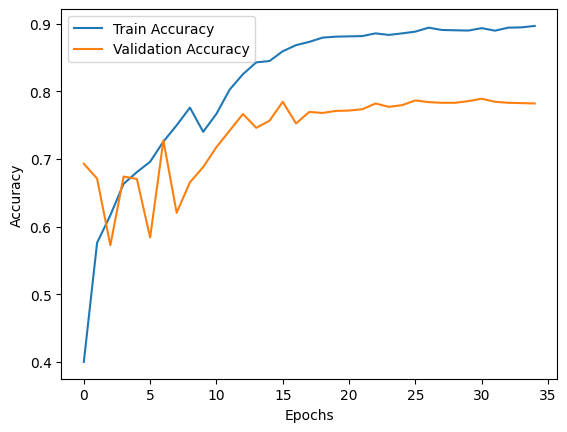

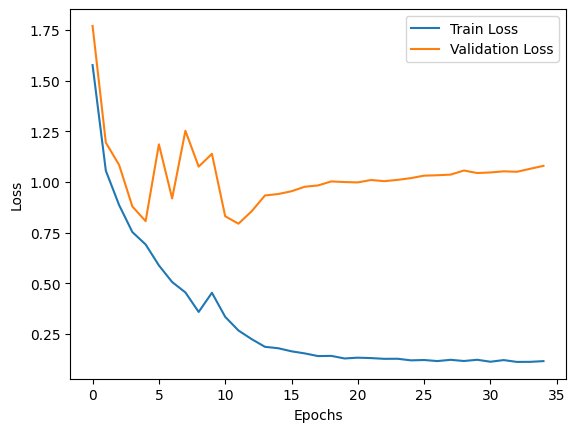

In [71]:
# Plot training and validation accuracy
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
irv2_model = load_model('irv2_model_multi.keras', custom_objects={'custom_loss': weighted_loss})

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = irv2_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 344ms/step - accuracy: 0.7617 - loss: 1.2003
Test Loss: 1.0881
Test Accuracy: 0.7882


In [74]:
# Get predictions and true labels
predictions = irv2_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class indices
true_labels = test_generator.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step


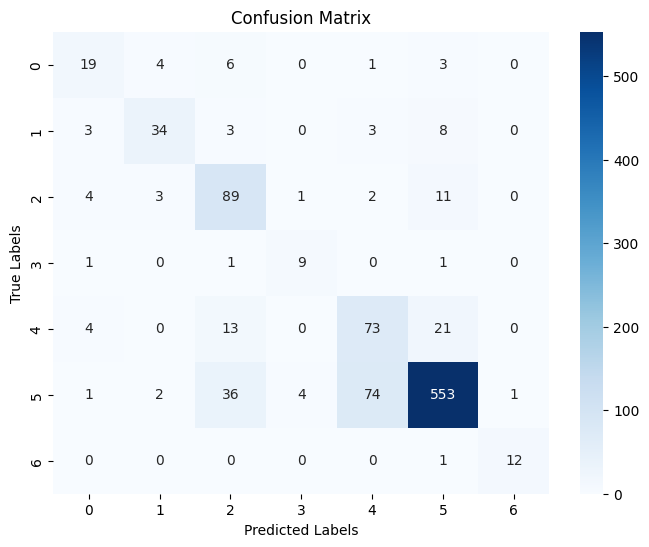

In [75]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [76]:
# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [77]:
# Specificity
specificities = []
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)
average_specificity = np.mean(specificities)

In [78]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {average_specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7882
Precision: 0.8184
Recall (Sensitivity): 0.7882
Specificity: 0.9541
F1-Score: 0.7978


## Model 4 - ResNet50 with adv soft attention

In [79]:
@tf.keras.utils.register_keras_serializable(package="Custom")
# Define SoftAttention Layer
class SoftAttention(Layer):
    def __init__(self, ch, m, concat_with_x=False, aggregate=False, **kwargs):
        self.channels = int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.i_shape = input_shape
        self.conv2d = self.add_weight(
            shape=(3, 3, self.channels, self.multiheads),
            initializer='he_uniform',
            name='kernel_conv2d'
        )
        self.bias_conv2d = self.add_weight(shape=(self.multiheads,),
                                           initializer='zeros',
                                           name='bias_conv2d')
        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        # Apply a 2D convolution to get attention maps
        conv_out = K.conv2d(
            x,
            kernel=self.conv2d,
            strides=(1,1),
            padding='same',
            data_format='channels_last'
        )
        conv_out = K.bias_add(conv_out, self.bias_conv2d)
        conv_out = Activation('relu')(conv_out)  # shape: (b, h, w, m)

        # Flatten spatial dims and apply softmax over h*w
        b, h, w, m = K.shape(conv_out)[0], K.shape(conv_out)[1], K.shape(conv_out)[2], K.shape(conv_out)[3]
        reshaped = K.reshape(conv_out, (b, h*w, m))
        reshaped = K.permute_dimensions(reshaped, (0,2,1)) # (b, m, h*w)

        softmax_alpha = K.softmax(reshaped, axis=-1)
        # Back to (b, h, w, m)
        softmax_alpha = K.reshape(softmax_alpha, (b, m, h, w))
        softmax_alpha = K.permute_dimensions(softmax_alpha, (0,2,3,1)) # (b, h, w, m)

        # Compute weighted features
        if not self.aggregate_channels:
            # Multiply x by each head and then concatenate
            # shape of softmax_alpha: (b, h, w, m)
            # shape of x: (b, h, w, c)
            # Expand alpha to (b, h, w, m, 1) and x to (b, h, w, 1, c)
            exp_alpha = K.expand_dims(softmax_alpha, axis=-1)    # (b, h, w, m, 1)
            x_exp = K.expand_dims(x, axis=3)                     # (b, h, w, 1, c)
            u = exp_alpha * x_exp
            # (b, h, w, m, c)
            u = K.reshape(u, (K.shape(u)[0], h, w, m*K.shape(u)[4]))
        else:
            # Aggregate (sum) across heads
            # (b, h, w, m) * (b, h, w, c) -> sum over m to get a single weighted map
            alpha_sum = K.sum(softmax_alpha, axis=-1, keepdims=True) # (b, h, w, 1)
            u = alpha_sum * x  # (b, h, w, c)

        if self.concat_input_with_scaled:
            o = Concatenate(axis=-1)([u, x])
        else:
            o = u

        # Return features and attention maps
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        if not self.aggregate_channels:
            # output features shape
            if self.concat_input_with_scaled:
                # (b, h, w, c+(c*m))
                return [(input_shape[0], input_shape[1], input_shape[2], input_shape[3]+(input_shape[3]*self.multiheads)),
                        (input_shape[0], input_shape[1], input_shape[2], self.multiheads)]
            else:
                # (b, h, w, (c*m)) since we combined heads
                return [(input_shape[0], input_shape[1], input_shape[2], input_shape[3]*self.multiheads),
                        (input_shape[0], input_shape[1], input_shape[2], self.multiheads)]
        else:
            if self.concat_input_with_scaled:
                return [(input_shape[0], input_shape[1], input_shape[2], input_shape[3]*2),
                        (input_shape[0], input_shape[1], input_shape[2], self.multiheads)]
            else:
                return [input_shape, (input_shape[0], input_shape[1], input_shape[2], self.multiheads)]

    def get_config(self):
        config = super(SoftAttention, self).get_config()
        config.update({
            'ch': self.channels,
            'm': self.multiheads,
            'concat_with_x': self.concat_input_with_scaled,
            'aggregate': self.aggregate_channels
        })
        return config

In [80]:
# Load ResNet50 without the top classifier layers
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None
)

In [81]:
# Extract the convolutional feature map from the model
conv = resnet.output

In [82]:
# Apply Soft Attention on the extracted convolutional features
attention_layer, map2 = SoftAttention(
    aggregate=True,
    m=16,
    concat_with_x=False,
    ch=int(conv.shape[-1]),
    name='soft_attention'
)(conv)

In [83]:
# Apply pooling on both branches to match dimensions
attention_layer = MaxPooling2D(pool_size=(2, 2), padding="same")(attention_layer)
conv = MaxPooling2D(pool_size=(2, 2), padding="same")(conv)

In [84]:
# Concatenate the original conv features with the attention-modulated features
conv = concatenate([conv, attention_layer])
conv = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [85]:
# Global average pooling followed by final classification
output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)

In [86]:
# Build the final model
resnet_model = Model(inputs=resnet.input, outputs=output)

In [87]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [88]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet50_SA_multi.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [89]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6
)

In [90]:
# Train the model
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 178s 561ms/step - accuracy: 0.4164 - loss: 1.7838 - val_accuracy: 0.0565 - val_loss: 2.1070 - learning_rate: 1.0000e-04
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 419ms/step - accuracy: 0.5630 - loss: 1.1919 - val_accuracy: 0.4130 - val_loss: 2.0048 - learning_rate: 1.0000e-04
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 421ms/step - accuracy: 0.6161 - loss: 0.8655 - val_accuracy: 0.4285 - val_loss: 2.0928 - learning_rate: 1.0000e-04
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.6383 - loss: 0.8045 - val_accuracy: 0.3395 - val_loss: 2.0912 - learning_rate: 1.0000e-04
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.6696 - loss: 0.6726 - val_accuracy: 0.5350 - val_loss: 1.3753 - learning_rate: 1.0000e-04
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 424ms/step - accuracy: 0.6565 - loss: 0.8009 - val_accuracy: 0.6980 - val_loss: 1.0387 - learning_rate: 1.0000e-04
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 4

In [91]:
# Save history
with open('resnet_SA_history.json', 'w') as f:
    json.dump(resnet_history.history, f)

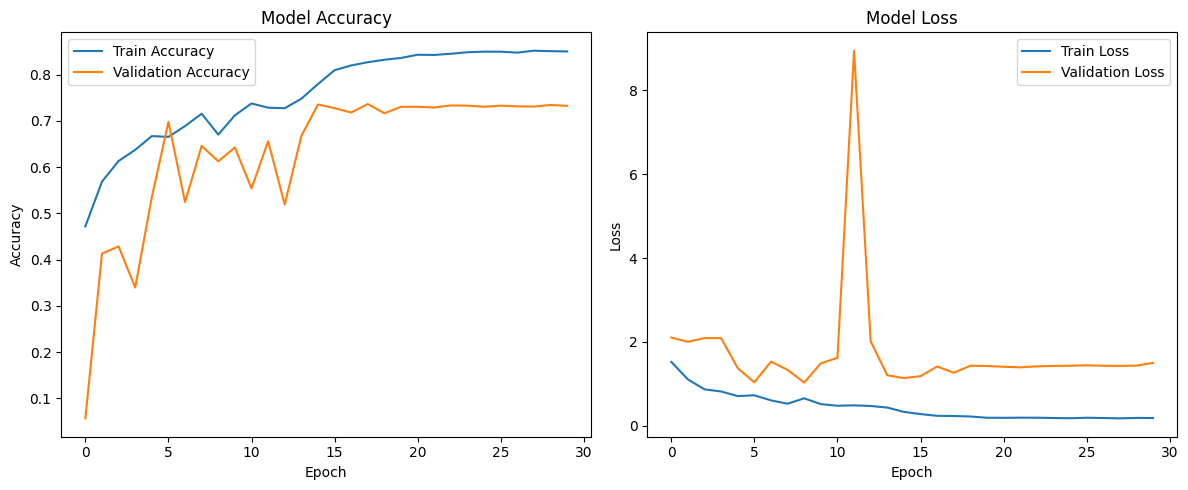

In [92]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot accuracy in the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss in the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [93]:
resnet_model = load_model('resnet50_SA_multi.keras', custom_objects={'custom_loss': weighted_loss})

In [94]:
# Evaluate the model on the test set
test_loss, test_accuracy = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7284 - loss: 1.1450
Test Loss: 1.0919
Test Accuracy: 0.7363


In [95]:
# Get predictions and true labels
predictions = resnet_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class indices
true_labels = test_generator.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step


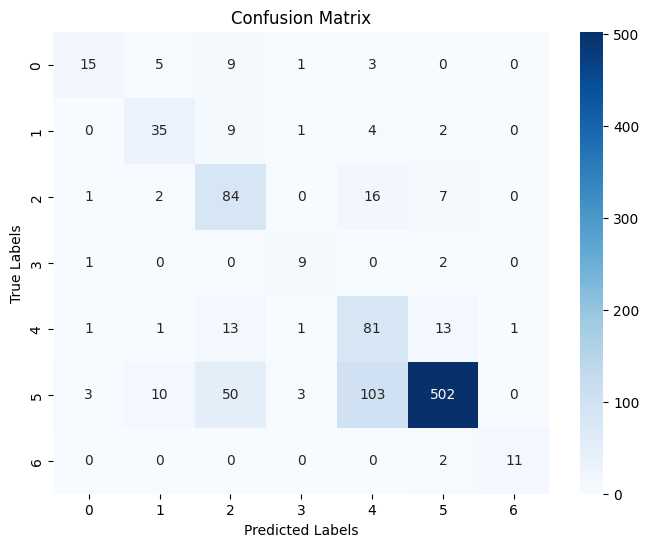

In [96]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [97]:
# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [98]:
# Specificity
specificities = []
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)
average_specificity = np.mean(specificities)

In [99]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {average_specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7363
Precision: 0.8129
Recall (Sensitivity): 0.7363
Specificity: 0.9509
F1-Score: 0.7570


### Comparison of all 4 accuracies

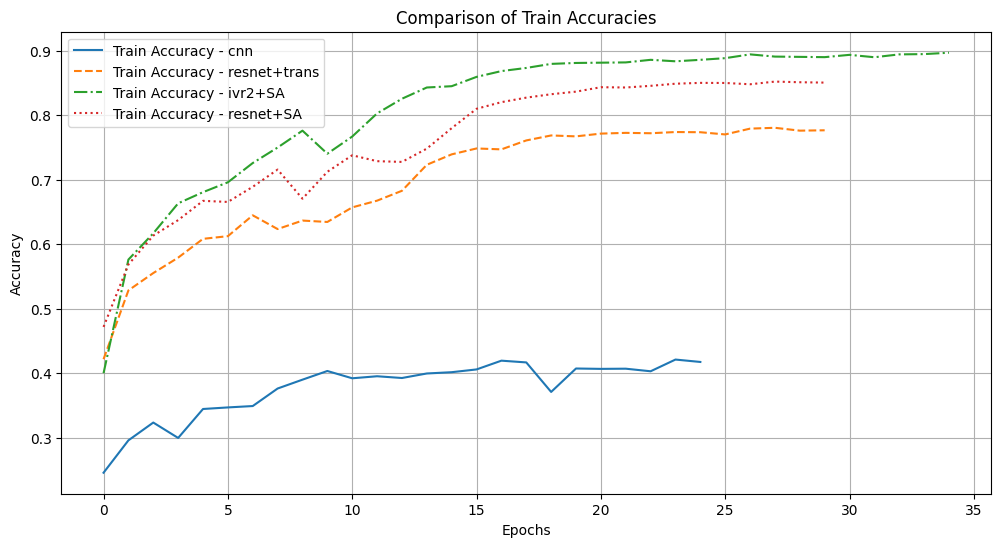

In [100]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy - cnn', linestyle='-')
plt.plot(trans_history.history['accuracy'], label='Train Accuracy - resnet+trans', linestyle='--')
plt.plot(full_history['accuracy'], label='Train Accuracy - ivr2+SA', linestyle='-.')
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy - resnet+SA', linestyle=':')

# Customize the plot
plt.title('Comparison of Train Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

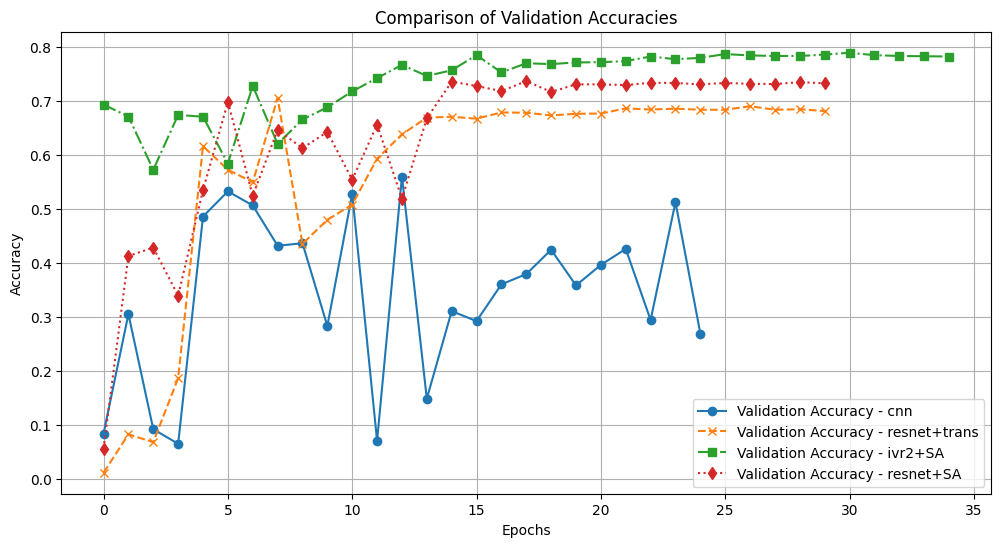

In [101]:
plt.figure(figsize=(12, 6))

# Plot validation accuracies
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy - cnn', linestyle='-', marker='o')
plt.plot(trans_history.history['val_accuracy'], label='Validation Accuracy - resnet+trans', linestyle='--', marker='x')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy - ivr2+SA', linestyle='-.', marker='s')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy - resnet+SA', linestyle=':', marker='d')

# Customize the plot
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()